# Metadata

```
Name: Maureen O'Shea (mo2cr@virginia.edu)
Course: DS5001
Date: 06 May 2022

Title: Implement PCA 

Description: Implement PCA from scratch using eigendecomposition of the term covariance matrix and explore. Create DCM scatterplots grouped by play and genre.  Explore components by play with bar charts and dendrograms (cosine and euclidean distance metric). 

Original Code Author: R.C.
Alvarado, Module 07 Lab, To implement PCA from scratch using eigendecomposition of the term covariance matrix and explore its application 
```

# Set Up

In [1]:
norm_docs = True # L2 norming
center_by_mean = False 
center_by_variance = False # Not supposed to ... Exaggerates significance of rare words
n_terms = 1000 # Number of significant words; feature space
k = 6 # Number of components

In [2]:
data_home = "./data"
local_lib = './lib'

In [3]:
OHCO = ['play_code', 'act_num']

In [4]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from scipy.linalg import norm

In [6]:
%matplotlib inline
import plotly_express as px
import seaborn as sns; sns.set()

# Prepare the Data

## Read in files

In [7]:
BOW = pd.read_csv(f'{data_home}/folger-BOW.csv', low_memory=False).set_index(OHCO+['term_str']).dropna()
VOCAB = pd.read_csv(f'{data_home}/folger-VOCAB2.csv', low_memory=False).set_index('term_str').dropna()
LIB = pd.read_csv(f'{data_home}/folger-LIB2.csv', low_memory=False).set_index('play_code').dropna()

## `LIB`

In [8]:
LIB.play_title = LIB.play_title.apply(lambda x: x[:20])
LIB.head(5)

,play_title,year,source_file_path,genre,play_id,play_len,n_acts,n_scenes,n_speeches,label
play_code,,,,,,,,,,
AWW,All's Well That Ends,1602,https://www.folgerdigitaltexts.org/AWW,comedy,0,11552,5,22,419,1602 (c): All's Well That Ends Well
Ant,Antony and Cleopatra,1606,https://www.folgerdigitaltexts.org/Ant,tragedy,1,12677,5,40,721,1606 (t): Antony and Cleopatra
AYL,As You Like It,1599,https://www.folgerdigitaltexts.org/AYL,comedy,2,8058,5,16,232,1599 (c): As You Like It
Err,The Comedy of Errors,1589,https://www.folgerdigitaltexts.org/Err,comedy,3,12097,5,11,495,1589 (c): The Comedy of Errors
Cor,Coriolanus,1607,https://www.folgerdigitaltexts.org/Cor,tragedy,4,20666,5,28,812,1607 (t): Coriolanus


## `VOCAB`

In [9]:
VOCAB

,term_rank,n,n_chars,n_tokens,tfidf_mean,df,dfidf,max_pos,n_pos,cat_pos,term_rank2
term_str,,,,,,,,,,,
thy,1,3074,3,1,0.131988,175,14.029811,po,2,"{'n1', 'po'}",1
lord,2,2091,4,1,0.092476,175,14.029811,n1,3,"{'n1', 'n1g', 'n2'}",2
good,3,1786,4,1,0.077583,182,4.292801,j,1,{'j'},3
come,4,1685,4,1,0.074410,181,5.707939,vvb,3,"{'vvi', 'vvb', 'vvn'}",4
well,5,1650,4,1,0.073146,181,5.707939,av,5,"{'uh_mi', 'av', 'n1', 'pns|vmb', 'av_j'}",5
...,...,...,...,...,...,...,...,...,...,...,...
burièd,3996,9,6,1,0.001425,8,36.251052,vvn,1,{'vvn'},362
bull,3997,9,4,1,0.001582,7,33.068186,n1,2,"{'n1-nn', 'n1'}",362
western,3998,9,7,1,0.001872,8,36.251052,j,1,{'j'},362


In [10]:
SIGS = VOCAB.sort_values('dfidf', ascending=False).head(n_terms).index

In [11]:
SIGS

Index(['highness', 'entreat', 'favor', 'note', 'beauty', 'ho', 'tomorrow',
       'often', 'office', 'pass',
       ...
       'trumpet', 'madness', 'reverend', 'purposes', 'main', 'fairly', 'id',
       'fierce', 'pause', 'melancholy'],
      dtype='object', name='term_str', length=1000)

## `TFIDF`

In [12]:
BOW.head(2)

n     tfidf
play_code act_num term_str               
1H4       1       absent    1.0  0.029245
                  accursed  1.0  0.032818

In [13]:
TFIDF = BOW.tfidf.unstack(fill_value=0)[SIGS]

In [14]:
TFIDF

term_str           highness   entreat     favor      note    beauty   ho  \
play_code act_num                                                          
1H4       1        0.037162  0.000000  0.000000  0.018581  0.000000  0.0   
          2        0.000000  0.000000  0.000000  0.000000  0.000000  0.0   
          3        0.000000  0.015994  0.000000  0.000000  0.031987  0.0   
          4        0.012543  0.000000  0.000000  0.012543  0.000000  0.0   
          5        0.000000  0.000000  0.036132  0.000000  0.000000  0.0   
...                     ...       ...       ...       ...       ...  ...   
WT        5        0.034372  0.000000  0.000000  0.017186  0.034372  0.0   
Wiv       2        0.000000  0.000000  0.000000  0.000000  0.000000  0.0   
          3        0.000000  0.000000  0.000000  0.000000  0.000000  0.0   
          4        0.000000  0.000000  0.000000  0.000000  0.000000  0.0   
          5        0.000000  0.000000  0.000000  0.000000  0.000000  0.0   

term_str           tomorrow     often    office  pass  ...   trumpet  \
play_code act_num                                      ...             
1H4       1        0.000000  0.000000  0.018447   0.0  ...  0.000000   
          2        0.000000  0.023218  0.000000   0.0  ...  0.000000   
          3        0.015994  0.000000  0.000000   0.0  ...  0.022164   
          4        0.037630  0.000000  0.024905   0.0  ...  0.017383   
          5        0.000000  0.000000  0.053806   0.0  ...  0.000000   
...                     ...       ...       ...   ...  ...       ...   
WT        5        0.000000  0.017062  0.017062   0.0  ...  0.000000   
Wiv       2        0.000000  0.000000  0.000000   0.0  ...  0.000000   
          3        0.000000  0.000000  0.000000   0.0  ...  0.000000   
          4        0.000000  0.030624  0.000000   0.0  ...  0.000000   
          5        0.000000  0.000000  0.000000   0.0  ...  0.000000   

term_str            madness  reverend  purposes  main    fairly        id  \
play_code act_num                                                           
1H4       1        0.000000  0.000000  0.025749   0.0  0.000000  0.000000   
          2        0.000000  0.000000  0.000000   0.0  0.000000  0.000000   
          3        0.000000  0.022164  0.000000   0.0  0.022164  0.000000   
          4        0.017383  0.017383  0.017383   0.0  0.000000  0.000000   
          5        0.000000  0.025036  0.000000   0.0  0.000000  0.000000   
...                     ...       ...       ...   ...       ...       ...   
WT        5        0.023816  0.000000  0.023816   0.0  0.000000  0.095266   
Wiv       2        0.000000  0.000000  0.000000   0.0  0.000000  0.000000   
          3        0.000000  0.000000  0.000000   0.0  0.000000  0.000000   
          4        0.000000  0.000000  0.000000   0.0  0.000000  0.000000   
          5        0.000000  0.000000  0.000000   0.0  0.000000  0.000000   

term_str           fierce     pause  melancholy  
play_code act_num                                
1H4       1           0.0  0.000000    0.000000  
          2           0.0  0.000000    0.032409  
          3           0.0  0.000000    0.000000  
          4           0.0  0.017383    0.000000  
          5           0.0  0.050072    0.000000  
...                   ...       ...         ...  
WT        5           0.0  0.000000    0.000000  
Wiv       2           0.0  0.000000    0.000000  
          3           0.0  0.000000    0.000000  
          4           0.0  0.000000    0.000000  
          5           0.0  0.000000    0.000000  

[185 rows x 1000 columns]

# DOC

In [15]:
lib_cols = ["play_title", "genre", "label", "year"]
DOC = pd.DataFrame(index=TFIDF.index)
DOC=DOC.join(LIB[lib_cols], on='play_code')

In [16]:
DOC['mean_tfidf'] = TFIDF.mean(1)
DOC['n_tokens'] = BOW.groupby(['play_code','act_num']).n.sum()

In [17]:
DOC

play_title    genre  \
play_code act_num                                  
1H4       1            Henry IV, Part 1  history   
          2            Henry IV, Part 1  history   
          3            Henry IV, Part 1  history   
          4            Henry IV, Part 1  history   
          5            Henry IV, Part 1  history   
...                                 ...      ...   
WT        5           The Winter's Tale  romance   
Wiv       2        The Merry Wives of W   comedy   
          3        The Merry Wives of W   comedy   
          4        The Merry Wives of W   comedy   
          5        The Merry Wives of W   comedy   

                                                  label  year  mean_tfidf  \
play_code act_num                                                           
1H4       1                  1597 (h): Henry IV, Part 1  1597    0.009367   
          2                  1597 (h): Henry IV, Part 1  1597    0.006889   
          3                  1597 (h): Henry IV, Part 1  1597    0.009900   
          4                  1597 (h): Henry IV, Part 1  1597    0.010056   
          5                  1597 (h): Henry IV, Part 1  1597    0.007808   
...                                                 ...   ...         ...   
WT        5                 1610 (r): The Winter's Tale  1610    0.009216   
Wiv       2        1600 (c): The Merry Wives of Windsor  1600    0.001014   
          3        1600 (c): The Merry Wives of Windsor  1600    0.003893   
          4        1600 (c): The Merry Wives of Windsor  1600    0.004543   
          5        1600 (c): The Merry Wives of Windsor  1600    0.003905   

                   n_tokens  
play_code act_num            
1H4       1          1213.0  
          2           823.0  
          3          1442.0  
          4          2021.0  
          5          1160.0  
...                     ...  
WT        5          1325.0  
Wiv       2             8.0  
          3           201.0  
          4           423.0  
          5           184.0  

[185 rows x 6 columns]

# Compute PCA

## Normalize doc vector lengths
We use TFIDF normalization, which scales documents by their pythagorean (Euclidean) length.

In [18]:
if norm_docs:
    print("L2 norming")
    TFIDF = TFIDF.apply(lambda x: x / norm(x), 1).fillna(0) # Euclidean norming

L2 norming


## Center term vectors

Note that we are taking the column-wise means -- the means for the _term_ vectors. Also, we do this *after* normalizing the documents.

**NOTE:** Some argue that centering alters the cosine angles.

In [19]:
if center_by_mean:
    print("Centering by mean")
    TFIDF = TFIDF - TFIDF.mean()

## Normalize term vector variance

We do **not** normalize variance, which we would normally do, such as with data containing divergent units of measure. \
This is because to do so would exaggerate the importance of rare words (see Ng, 2008: 6m40s–8m00s).

In [20]:
if center_by_variance:
    print("Centering by variance")
    TFIDF = TFIDF / TFIDF.std()

## Compute Covariance Matrix

$n = |X| = |Y|$

$Cov(X,Y) = \dfrac{\sum_{i=1}^{n} (x_i - \mu_X) (y_i - \mu_Y)}{n - 1} = \dfrac{XY}{n-1}$

In [21]:
COV = TFIDF.cov()

In [22]:
#COV

In [23]:
COV.stack().sort_values().loc['city']

term_str
madam      -0.000492
liege      -0.000268
ring       -0.000230
cousin     -0.000228
highness   -0.000222
              ...   
walls       0.000437
gates       0.000584
town        0.000622
people      0.000929
city        0.001405
Length: 1000, dtype: float64

## Decompose the Matrix

There a at least three options to choose from. We go with SciPy's Hermitian Eigendecomposition \
method `eigh()`, since our covarience matrix is symmetric.

Return values (from the docs):

>`w(…, M) ndarray`\
The eigenvalues in ascending order, each repeated according to its multiplicity.

> `v{(…, M, M) ndarray, (…, M, M) matrix}`\
The column v[:, i] is the normalized eigenvector corresponding to the eigenvalue w[i]. Will return a matrix object if a is a matrix object.

- Eigenvalues are returned in ascending order.
- Eigenvectors are returned with columns sorted in the order of the eigenvalues.

In [24]:
from scipy.linalg import eigh

In [25]:
%time eig_vals, eig_vecs = eigh(COV)

CPU times: user 216 ms, sys: 23.6 ms, total: 239 ms
Wall time: 237 ms


## Convert eigen data to dataframes

In [26]:
EIG_VEC = pd.DataFrame(eig_vecs, index=COV.index, columns=COV.index)
EIG_VAL = pd.DataFrame(eig_vals, index=COV.index, columns=['eig_val'])
EIG_VAL.index.name = 'term_str'

In [27]:
EIG_VEC.iloc[:10, :10].style.background_gradient(cmap='GnBu', high=.5)

term_str,highness,entreat,favor,note,beauty,ho,tomorrow,often,office,pass
term_str,,,,,,,,,,
highness,0.087306,0.174272,0.323207,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
entreat,0.075538,0.209360,0.105695,0.054564,0.013942,0.071032,0.002847,0.040531,0.057984,0.028672
favor,-0.127637,-0.084199,0.164928,0.045510,0.038765,0.156544,-0.055823,0.003064,0.009728,-0.165091
note,0.040036,0.108900,-0.106438,0.070002,0.024916,0.088686,0.053978,0.004681,-0.086070,0.091717
beauty,-0.026076,0.000158,-0.020648,-0.024804,0.048893,-0.010151,0.022969,0.007530,-0.000095,-0.027391
ho,0.036799,-0.027208,-0.019335,0.040864,-0.040733,0.019628,0.054146,-0.067505,-0.034439,0.014021
tomorrow,-0.005271,-0.074085,-0.000453,-0.063286,-0.000908,0.012576,0.019119,0.005732,0.005510,0.063894
often,0.020363,0.055602,0.009991,-0.034324,-0.020946,0.016908,-0.000431,0.038172,0.011561,0.006013
office,0.004486,0.038151,-0.050288,-0.033953,-0.029520,0.070492,0.005243,0.025714,0.024517,-0.032106


In [28]:
EIG_VAL

,eig_val
term_str,
highness,-1.243628e-17
entreat,-8.769792e-18
favor,-5.026754e-18
note,-2.710742e-18
beauty,-2.628409e-18
...,...
fairly,1.333861e-02
id,1.403657e-02
fierce,1.582731e-02


## Pick Top K Components

We pick these based on explained variance.

In [29]:
EIG_IDX = EIG_VAL.eig_val.sort_values(ascending=False).head(k) #.index

In [30]:
COMPS = EIG_VEC[EIG_IDX.index].T # EIG_VEC.T.loc[EIG_IDX]
COMPS.index = [i for i in range(COMPS.shape[0])]
COMPS.index.name = 'pc_id'

In [31]:
COMPS

term_str,highness,entreat,favor,note,beauty,ho,tomorrow,often,office,pass,...,trumpet,madness,reverend,purposes,main,fairly,id,fierce,pause,melancholy
pc_id,,,,,,,,,,,,,,,,,,,,,
0,0.071456,-0.014976,-0.008886,-0.039239,-0.031696,-0.043502,0.000353,-0.010485,0.003751,0.006109,...,0.020937,-0.022581,0.003218,0.010875,0.014018,-0.006036,-0.014416,0.016434,0.017905,-0.006978
1,0.012385,0.013986,0.010189,-0.037175,0.031656,-0.096892,-0.029654,-0.021331,-0.010578,-0.011613,...,-0.038266,-0.040214,-0.005324,-0.032299,-0.004487,-0.006584,-0.045970,-0.020951,0.008603,0.022265
2,-0.128373,-0.019802,-0.032767,-0.017101,-0.020301,0.006795,0.028033,-0.030693,-0.001195,-0.009894,...,0.025190,0.002991,-0.033669,0.010531,-0.013377,0.010880,-0.019201,0.012491,0.014946,0.006022
3,0.125569,-0.025343,0.005023,0.012680,-0.012166,-0.059035,-0.072261,-0.004737,0.011270,0.048050,...,-0.028703,-0.039921,0.035698,0.003965,0.029664,0.026981,0.002929,-0.010393,-0.017834,-0.015711
4,-0.005715,-0.004158,-0.005869,0.070003,0.039939,-0.013229,0.066010,-0.010466,0.045569,-0.022215,...,0.043292,-0.002849,-0.014591,0.018434,0.001287,0.024415,-0.033854,0.010961,0.011624,-0.017948
5,0.017925,0.012175,-0.013702,-0.045552,0.031510,0.013157,0.037077,-0.001860,0.018550,-0.001511,...,-0.003654,0.042859,0.035604,0.016826,-0.009556,0.029129,0.055749,-0.008842,0.021275,0.001833


## See Projected Components onto Vocabulary (Loadings)

Loadings sow the contribution of each term to the component. \
We'll just look at the topi 10 words for the first two components in the Book version.

In [32]:
LOADINGS = COMPS.T

In [33]:
LOADINGS.head(10).style.background_gradient(cmap='GnBu', high=.5)

pc_id,0,1,2,3,4,5
term_str,,,,,,
highness,0.071456,0.012385,-0.128373,0.125569,-0.005715,0.017925
entreat,-0.014976,0.013986,-0.019802,-0.025343,-0.004158,0.012175
favor,-0.008886,0.010189,-0.032767,0.005023,-0.005869,-0.013702
note,-0.039239,-0.037175,-0.017101,0.012680,0.070003,-0.045552
beauty,-0.031696,0.031656,-0.020301,-0.012166,0.039939,0.031510
ho,-0.043502,-0.096892,0.006795,-0.059035,-0.013229,0.013157
tomorrow,0.000353,-0.029654,0.028033,-0.072261,0.066010,0.037077
often,-0.010485,-0.021331,-0.030693,-0.004737,-0.010466,-0.001860
office,0.003751,-0.010578,-0.001195,0.011270,0.045569,0.018550


## Create Component Info Table

### Add Opposites

In [34]:
COMPINF = pd.DataFrame(index=COMPS.index)
for i in range(k):
    for j in [0, 1]:
        top_terms = ' '.join(LOADINGS.sort_values(i, ascending=bool(j)).head(7).index.to_list())
        COMPINF.loc[i, j] = top_terms
COMPINF = COMPINF.rename(columns={0:'pos', 1:'neg'})

In [35]:
COMPINF

,pos,neg
pc_id,,
0,duke lords crown cousin uncle majesty brother,master ring mistress madam music lady wife
1,duke ring daughter brother cousin marry uncle,gods em nature people sword general hes
2,master money home town today march flies,madam queen lady duke highness em daughter
3,em duke highness money people master ring,madam brother tears sons kill boy mother
4,cousin wit prince loves sing madam music,master husband queen sons wife mistress duke
5,daughter brother fathers prince marry cousin maid,madam ring money flies fight shadow lords


### Add Eigen Values and Explained Variance

In [36]:
COMPINF['eig_val'] = EIG_IDX.reset_index(drop=True).to_frame()
COMPINF['exp_var'] = COMPINF.eig_val / COMPINF.eig_val.sum()

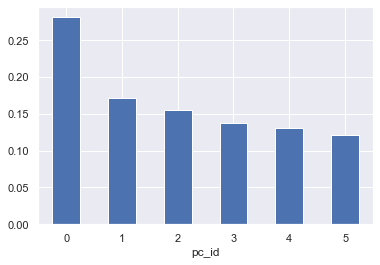

In [37]:
COMPINF.exp_var.sort_values(ascending=False).head(k).plot.bar(rot=0);

## Create Document-Component Table

We get the dot product of the DTM matrix and the new component matrix (as the loadings), which we will call DCM -- for document-component matrix. \
This has the effect of replacing the features of the DTM with the features of the transposed component matrix.

In [38]:
DCM = TFIDF.dot(LOADINGS) 

In [39]:
DCM

pc_id                     0         1         2         3         4         5
play_code act_num                                                            
1H4       1        0.440794 -0.128760 -0.027911 -0.078468  0.111139  0.091169
          2        0.355116 -0.052639 -0.114124 -0.058229 -0.031719  0.118311
          3        0.353709 -0.148743 -0.034617 -0.084189  0.085032  0.097857
          4        0.377659 -0.200887 -0.046150 -0.102451  0.081427  0.111971
          5        0.334019 -0.120352  0.011179 -0.183276  0.112702  0.161568
...                     ...       ...       ...       ...       ...       ...
WT        5        0.097035 -0.153025 -0.348963 -0.154212 -0.118905  0.304233
Wiv       2       -0.013846  0.045021  0.058350  0.054829  0.052659 -0.126377
          3       -0.170321  0.113999  0.036969  0.041560 -0.267567  0.183853
          4       -0.053183 -0.041742 -0.023796 -0.069438 -0.093525  0.153961
          5       -0.093802 -0.024193  0.108093 -0.008771 -0.175448 -0.008829

[185 rows x 6 columns]

# DCM Scatterplots

## PC 0 and 1

In [40]:
(DOC.index != DCM.index).sum()

0

In [41]:
DOC.head()

play_title    genre                       label  \
play_code act_num                                                          
1H4       1        Henry IV, Part 1  history  1597 (h): Henry IV, Part 1   
          2        Henry IV, Part 1  history  1597 (h): Henry IV, Part 1   
          3        Henry IV, Part 1  history  1597 (h): Henry IV, Part 1   
          4        Henry IV, Part 1  history  1597 (h): Henry IV, Part 1   
          5        Henry IV, Part 1  history  1597 (h): Henry IV, Part 1   

                   year  mean_tfidf  n_tokens  
play_code act_num                              
1H4       1        1597    0.009367    1213.0  
          2        1597    0.006889     823.0  
          3        1597    0.009900    1442.0  
          4        1597    0.010056    2021.0  
          5        1597    0.007808    1160.0

In [42]:
try:
    DOC = DOC.join(DCM)
except:
    pass

In [43]:
DOC

play_title    genre  \
play_code act_num                                  
1H4       1            Henry IV, Part 1  history   
          2            Henry IV, Part 1  history   
          3            Henry IV, Part 1  history   
          4            Henry IV, Part 1  history   
          5            Henry IV, Part 1  history   
...                                 ...      ...   
WT        5           The Winter's Tale  romance   
Wiv       2        The Merry Wives of W   comedy   
          3        The Merry Wives of W   comedy   
          4        The Merry Wives of W   comedy   
          5        The Merry Wives of W   comedy   

                                                  label  year  mean_tfidf  \
play_code act_num                                                           
1H4       1                  1597 (h): Henry IV, Part 1  1597    0.009367   
          2                  1597 (h): Henry IV, Part 1  1597    0.006889   
          3                  1597 (h): Henry IV, Part 1  1597    0.009900   
          4                  1597 (h): Henry IV, Part 1  1597    0.010056   
          5                  1597 (h): Henry IV, Part 1  1597    0.007808   
...                                                 ...   ...         ...   
WT        5                 1610 (r): The Winter's Tale  1610    0.009216   
Wiv       2        1600 (c): The Merry Wives of Windsor  1600    0.001014   
          3        1600 (c): The Merry Wives of Windsor  1600    0.003893   
          4        1600 (c): The Merry Wives of Windsor  1600    0.004543   
          5        1600 (c): The Merry Wives of Windsor  1600    0.003905   

                   n_tokens         0         1         2         3         4  \
play_code act_num                                                               
1H4       1          1213.0  0.440794 -0.128760 -0.027911 -0.078468  0.111139   
          2           823.0  0.355116 -0.052639 -0.114124 -0.058229 -0.031719   
          3          1442.0  0.353709 -0.148743 -0.034617 -0.084189  0.085032   
          4          2021.0  0.377659 -0.200887 -0.046150 -0.102451  0.081427   
          5          1160.0  0.334019 -0.120352  0.011179 -0.183276  0.112702   
...                     ...       ...       ...       ...       ...       ...   
WT        5          1325.0  0.097035 -0.153025 -0.348963 -0.154212 -0.118905   
Wiv       2             8.0 -0.013846  0.045021  0.058350  0.054829  0.052659   
          3           201.0 -0.170321  0.113999  0.036969  0.041560 -0.267567   
          4           423.0 -0.053183 -0.041742 -0.023796 -0.069438 -0.093525   
          5           184.0 -0.093802 -0.024193  0.108093 -0.008771 -0.175448   

                          5  
play_code act_num            
1H4       1        0.091169  
          2        0.118311  
          3        0.097857  
          4        0.111971  
          5        0.161568  
...                     ...  
WT        5        0.304233  
Wiv       2       -0.126377  
          3        0.183853  
          4        0.153961  
          5       -0.008829  

[185 rows x 12 columns]

In [44]:
# box plots according to genre
px.scatter(DCM, 0, 1, color=DOC.genre, symbol=DOC.genre, 
           size=np.abs(DOC.mean_tfidf), hover_name=DOC.label, 
           marginal_x='box', marginal_y='box', height=1000)

/Users/maureenoshea/opt/anaconda3/lib/python3.7/site-packages/google/colab/data_table.py:30: UserWarning:

IPython.utils.traitlets has moved to a top-level traitlets package.



In PC0, the outlier point for history genre is Henry VIII. The clustering for PC0 appears to be history and everything else. The tragedy play within the history cluster is Titus Andronicus. 

In [45]:
# box plots according to play title
px.scatter(DCM, 0, 1, color=DOC.genre, symbol=DOC.play_title, 
           size=np.abs(DOC.mean_tfidf), hover_name=DOC.label, 
           marginal_x='box', marginal_y='box', height=1000)

With the box plots according to play_title, for PC0 the history title that is clustered with the non-history genres is Henry VIII.  The tragedy title clustered with history titles is Titus Andronicus.

In [46]:
COMPINF.loc[[0,1]]

,pos,neg,eig_val,exp_var
pc_id,,,,
0,duke lords crown cousin uncle majesty brother,master ring mistress madam music lady wife,0.028562,0.281175
1,duke ring daughter brother cousin marry uncle,gods em nature people sword general hes,0.017481,0.172093


PC0 words associated with history genre are: duke lords crown cousin uncle majesty brother

## PCA 2 and 3

In [47]:
px.scatter(DCM, 2, 3, color=DOC.genre, symbol=DOC.genre, 
           size=np.abs(DOC.mean_tfidf), hover_name=DOC.label, 
           marginal_x='box', marginal_y='box', height=1000)

In [48]:
px.scatter(DCM, 2, 3, color=DOC.genre, symbol=DOC.play_title, 
           size=np.abs(DOC.mean_tfidf), hover_name=DOC.label, 
           marginal_x='box', marginal_y='box', height=1000)

In [49]:
COMPINF.loc[[2,3]]

,pos,neg,eig_val,exp_var
pc_id,,,,
2,master money home town today march flies,madam queen lady duke highness em daughter,0.015827,0.155811
3,em duke highness money people master ring,madam brother tears sons kill boy mother,0.014037,0.138182


In [50]:
px.scatter(DCM, 4, 5, color=DOC.genre, symbol=DOC.genre, 
           size=np.abs(DOC.mean_tfidf), hover_name=DOC.label, 
           marginal_x='box', marginal_y='box', height=1000)

In [51]:
px.scatter(DCM, 4, 5, color=DOC.genre, symbol=DOC.play_title, 
           size=np.abs(DOC.mean_tfidf), hover_name=DOC.label, 
           marginal_x='box', marginal_y='box', height=1000)

# Loadings Scatterplots

In [52]:
try:
    VOCAB2 = VOCAB.join(LOADINGS, how='right').reset_index()
except:
    pass

In [53]:
#VOCAB2

## PC 0 and 1

In [54]:
px.scatter(VOCAB2, 0, 1, 
           size='tfidf_mean', color='dfidf', 
           hover_name='term_str', 
           hover_data=['max_pos'], 
           marginal_x='box', marginal_y='box', 
           height=1000, width=1000)

## PC 2 and 3

In [55]:
px.scatter(VOCAB2, 2, 3, 
           size='tfidf_mean', color='dfidf', 
           hover_name='term_str', hover_data=['max_pos'], 
           marginal_x='box', marginal_y='box', 
           height=1000, width=1000)

## PC 4 and 5 

In [56]:
px.scatter(VOCAB2, 4, 5, 
           size='tfidf_mean', color='dfidf', 
           hover_name='term_str', hover_data=['max_pos'], 
           marginal_x='box', marginal_y='box', 
           height=1000, width=1000)

# Components by PLAY

In [57]:
LIB.head(2)

,play_title,year,source_file_path,genre,play_id,play_len,n_acts,n_scenes,n_speeches,label
play_code,,,,,,,,,,
AWW,All's Well That Ends,1602,https://www.folgerdigitaltexts.org/AWW,comedy,0,11552,5,22,419,1602 (c): All's Well That Ends Well
Ant,Antony and Cleopatra,1606,https://www.folgerdigitaltexts.org/Ant,tragedy,1,12677,5,40,721,1606 (t): Antony and Cleopatra


In [58]:
DOC.head(2)

play_title    genre                       label  \
play_code act_num                                                          
1H4       1        Henry IV, Part 1  history  1597 (h): Henry IV, Part 1   
          2        Henry IV, Part 1  history  1597 (h): Henry IV, Part 1   

                   year  mean_tfidf  n_tokens         0         1         2  \
play_code act_num                                                             
1H4       1        1597    0.009367    1213.0  0.440794 -0.128760 -0.027911   
          2        1597    0.006889     823.0  0.355116 -0.052639 -0.114124   

                          3         4         5  
play_code act_num                                
1H4       1       -0.078468  0.111139  0.091169  
          2       -0.058229 -0.031719  0.118311

In [59]:
import sys; sys.path.append(local_lib)
from hac2 import HAC

In [60]:
BCM = DCM.groupby('play_code').mean().sort_index()
BCM.index = LIB.loc[list(BCM.index)].label

In [61]:
BCM.sort_values(0, ascending=False).style.background_gradient(cmap='GnBu', high=.5, axis=0)

pc_id,0,1,2,3,4,5
label,,,,,,
"1591 (h): Henry VI, Part 1",0.470490,-0.110263,-0.236032,-0.102098,-0.184103,0.007906
"1590 (h): Henry VI, Part 3",0.408436,-0.073819,-0.164176,-0.170614,-0.206002,0.038961
1595 (h): Richard II,0.407837,-0.097821,-0.136113,-0.135010,-0.015952,0.051504
"1590 (h): Henry VI, Part 2",0.398637,0.007647,-0.207281,0.015206,-0.152951,0.009923
"1597 (h): Henry IV, Part 1",0.372259,-0.130276,-0.042325,-0.101323,0.071716,0.116175
1598 (h): Henry V,0.365975,-0.187074,-0.041438,-0.009628,0.021391,0.104090
1592 (h): Richard III,0.365104,-0.062705,-0.211913,-0.200869,-0.134084,0.113636
1596 (h): King John,0.282764,-0.157171,-0.078191,-0.161896,-0.019021,0.080895
"1597 (h): Henry IV, Part 2",0.269914,-0.096257,-0.090318,-0.005433,-0.002358,0.036395


In [62]:
px.bar(BCM.sort_values(0), height=1200, orientation='h', barmode='relative')

When comparing Henry VIII to the other history-genre plays, PC_ID = 3 (the 4th PC) has a postive value for Henry VIII (0.16).  Henry VI part 2, also has a small positive value (0.015). For all other histories, PC_ID = 3 has a negative value. 

In [63]:
print(COMPINF.loc[1, ['pos','neg']].values)

['duke ring daughter brother cousin marry uncle'
 'gods em nature people sword general hes']


In [64]:
print(COMPINF.loc[3, ['pos','neg']].values)

['em duke highness money people master ring'
 'madam brother tears sons kill boy mother']


## Dendrograms

In [65]:
import sys; sys.path.append(local_lib)
from hac2 import HAC

In [66]:
HAC.dist_metric

'cosine'

<Figure size 432x288 with 0 Axes>

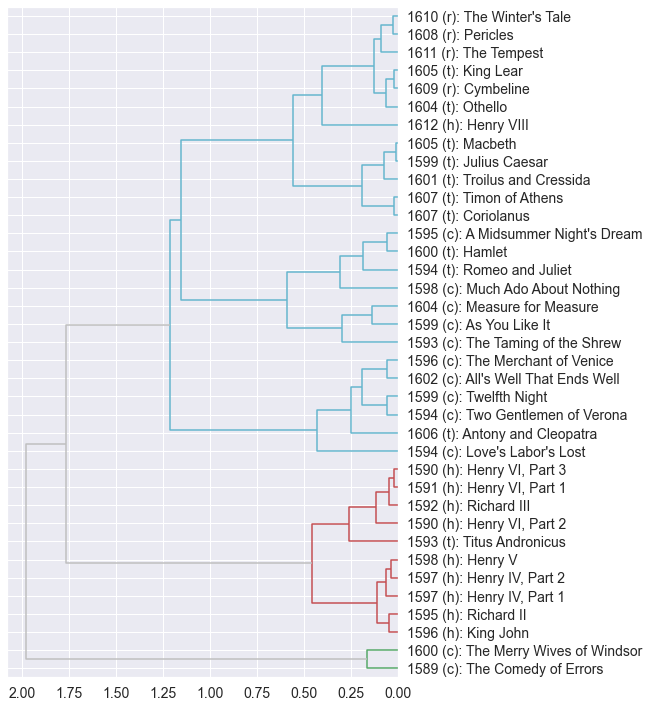

In [67]:
dend1 = HAC(BCM)
dend1.w = 7
dend1.color_thresh = 1.7
dend1.plot()

<Figure size 432x288 with 0 Axes>

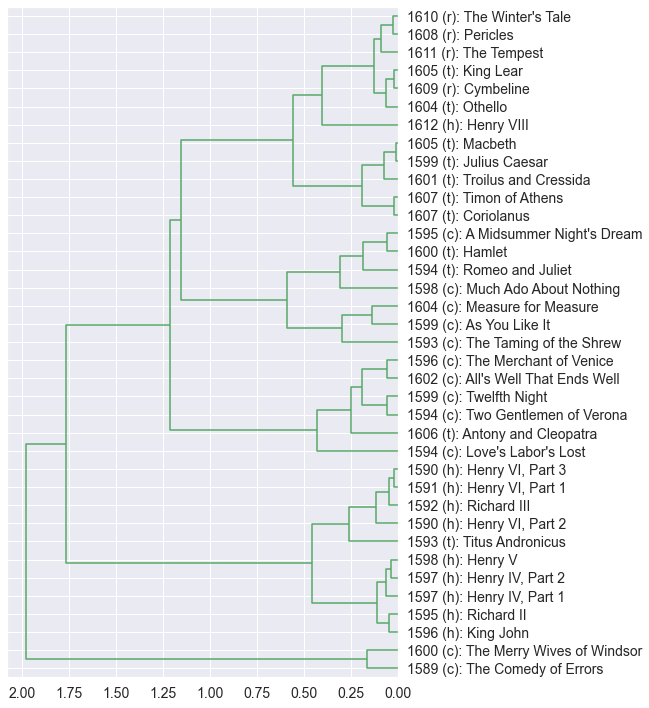

In [68]:
dend3 = HAC(BCM)
dend3.w = 7
dend3.color_thresh = 2.5
dend3.plot()

<Figure size 432x288 with 0 Axes>

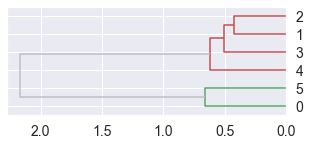

In [69]:
dend4 = HAC(DCM.T)
dend4.w = 5
dend4.color_thresh = 2
dend4.plot()

# Save

In [70]:
!ls {data_home}

folger-API.csv                  folger-LIB2.csv
folger-BOW.csv                  folger-PCA_COMPS.csv
folger-BOW_REDUCED.csv          folger-PCA_DCM.csv
folger-CORPUS.csv               folger-PCA_DOC.csv
folger-CORPUS2.csv              folger-PCA_THETA.csv
folger-GENSIM_DOCS.csv          folger-TOKEN.csv
folger-LDA_PHI-20.csv           folger-TOKEN2.csv
folger-LDA_PHI_COMEDY-20.csv    folger-VADER_DOC.csv
folger-LDA_PHI_HISTORY-20.csv   folger-VOCAB.csv
folger-LDA_PHI_ROMANCE-20.csv   folger-VOCAB2.csv
folger-LDA_PHI_TRAGEDY-20.csv   folger-VOCAB_NG2.csv
folger-LDA_THETA-20.csv         folger-W2V.csv
folger-LDA_THETA_COMEDY-20.csv  folger-W2V_VOCAB.csv
folger-LDA_THETA_HISTORY-20.csv glove50.csv
folger-LDA_THETA_ROMANCE-20.csv salex_bing.csv
folger-LDA_THETA_TRAGEDY-20.csv salex_combo.csv
folger-LDA_TOPIC-20.csv         salex_combo2.csv
folger-LDA_TOPIC_COMEDY-20.csv  salex_gi.csv
folger-LDA_TOPIC_HISTORY-20.csv salex_gi2.csv
folger-LDA_TOPIC_ROMANCE-20.csv salex_labmt.csv
folger-LDA_TO

In [71]:
data_prefix = 'folger'

In [72]:
COMPINF.to_csv(f"{data_home}/{data_prefix}-PCA_COMPS.csv")
LOADINGS.to_csv(f"{data_home}/{data_prefix}-PCA_THETA.csv")
DCM.to_csv(f"{data_home}/{data_prefix}-PCA_DCM.csv")
DOC.to_csv(f"{data_home}/{data_prefix}-PCA_DOC.csv")